In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import os
import seaborn as sb
import sklearn.linear_model as sk_lin
import sklearn.ensemble as ens
import scipy.stats as st

### 1) Decision Tree/ Random Forest:

The following cell contains four functions that combine give a simple decision tree set up function. The output is a list that can be used on a testing input to classify that test based on the training data ('treetest.py'). The actual testing stage has been included in the code cell below this one. In this example, the input data has 3 training features and one prediction feature 'y'.   
Function list:  
decision_split - takes in the data, the entropy score for the dataset as a whole and an indication of which column is the predictor column. It returns a divided dataset and the feature on which the data was split.   
decision_entropy - takes in a value (in this case a proportion of ones:zeros) and returns an entropy score.  
binary_decision_tree - takes in binary data, column headers for the data and the predictor column name. An optional argumnet is 'count', this is used in when the function recursively calls itself to measure tree depth.    
txt_to_data: this takes in a csv txt file and outputs the data in a way that is more amenable to use with the function, and also outputs a header list.   
N.B. The function prints lots of output, it is very messy, it is just to allow the user to view it, in reality it is not needed for the function to work.    
example output = [00, 00201, 00211, 00201101, 00201110, 00211101, 00211110] 
00 = unsplit, 00201 = this element represents the zeros result for the first split that was taken over feature 2 and the most common 'y' value in this subset is 1.
match a prediction input to a corresponding list element and take the dominant y value in this split as the y value for that input.   
Also, note that the SUM of entropys at each split are generally decreasing as iterations increase - though the individual entropy may increase. They are far from perfect though, this is ok as they are supposed to be weak classifiers (taken together in a forest they are an effective classifier).

In [37]:
def decision_split(datarino, pre_ent, predict_column):
    columnlist = list(datarino.drop(predict_column, axis = 1).columns.values) # don't want to split on the predictor list.
    max_infogain = 0                              # these variables will hold the maximum information gain from each possible
    final_zeros = 0                               # feature split and hold onto the associated data subsets and feature name. 
    final_ones = 0
    featname = ''
    prop_ones_z = 0
    prop_ones_o = 0
    for i in columnlist:
        
        # to find the ideal subset, for each feature the data set is split into ones and zeros in that feature, the entropy
        # of the resulting subsets is then computed (with weights) and summed, an information gain can then be computed as 
        # pre split entropy was included as a function argument. 
        
        zeros = datarino[(datarino[i]<1)]       
        ones = datarino[(datarino[i]>0.5)]
        
        # The entropy calculation of the zero subset will not work if there are no zeros, thus there is an exception.
        # The same happens for the one subset. (if there are no zeros then the entropy is zero). 
        
        try:
            zero_entropy = decision_entropy(float(zeros[(zeros[predict_column] < 1)].count()[predict_column])/
                float(len(list(zeros[predict_column]))))
        except:
            zero_entropy = 0
        try:
            one_entropy = decision_entropy(float(ones[(ones[predict_column] > 0)].count()[predict_column])/
                float(len(list(ones[predict_column]))))
        except:
            one_entropy = 0
        try:
            info_gain = pre_ent - (float(len(zeros)/float(len(datarino)))*zero_entropy + 
                    (float(len(ones))/float(len(datarino)))*one_entropy)
        except:
            info_gain = 0
        # If this is a terminal node, we will need to know the proportions of ones and zeros in predictor columns to determine 
        # class of the leaf when testing.
        if info_gain > max_infogain:
            final_zeros = zeros
            final_ones = ones
            featname = str(i[-1])
            prop_ones_z = float(zeros[(zeros[predict_column] > 0)].count()[predict_column])/len(zeros[predict_column])
            prop_ones_o = float(ones[(ones[predict_column] > 0)].count()[predict_column])/len(zeros[predict_column])
    if prop_ones_z >= 0.5:
        z_class = '1'
    else:
        z_class = '0'
    if prop_ones_o >= 0.5:
        o_class = '1'
    else:
        o_class = '0'
    print(final_zeros, '\n', '\n', 'split on ' + str(featname), '\n', '\n',final_ones, '\n')
    return(final_zeros,final_ones,featname, z_class, o_class) # reurn the two new data subsets and the feature name on which the original data
                                            # was split. 

def decision_entropy(val):
    res = 0
    if math.isnan(-val * np.log2(val) - (1-val) * np.log2((1-val))) == False: # if the entropy equation deosnt work it is because
        res = -val * np.log2(val) - (1-val) * np.log2((1-val)) # one the values is zeros (i.e. entropy = zero). 
    return res

def binary_decision_tree(dict_data, predict_column_name, column_titles, count = 0):
    done = True
    newdict_data = defaultdict(list)
    for key,value in dict_data.items():
        if len(key) > count * 2:
            pandas_val = pd.DataFrame(value, columns = column_titles)
            pre_split_entropy = decision_entropy((pandas_val[(pandas_val[predict_column_name] > 0)].count()[predict_column_name])
                /(len(list(pandas_val[predict_column_name]))))   
            print('datasplit:', key, '   size of datasplit:', len(value), '   entropy of datasplit:', pre_split_entropy, '\n')
            if (pre_split_entropy < 0.45 or pandas_val[(pandas_val[predict_column_name] > 0)].count()[predict_column_name] < 3 
                or pandas_val[(pandas_val[predict_column_name] < 0.5)].count()[predict_column_name] < 3):
                continue
            else:
                newsplit = decision_split(pandas_val, pre_split_entropy, 'y')
                if isinstance(newsplit[0], pd.DataFrame):
                    newdict_data[key+ newsplit[2] + '0' + newsplit[3]] = newsplit[0]
                if isinstance(newsplit[1], pd.DataFrame):
                    newdict_data[key+ newsplit[2] + '1' + newsplit[4]] = newsplit[1]
                done = False           # if a data subset/node can be split, then the algorithm is not done, the new subsets
                                       # will need to be tested for min entropy/size and potentially split again. 
    
            
    if done == True:                   # if all current data subsets have minimal entropy/size, return the split list.
        return list(sorted(list(dict_data.keys()), key = len))
    elif done == False:
        dict_data.update(newdict_data) # if data subsets have been split, update data to contain the new splits.
        print(sorted(list(dict_data.keys()), key = len), '\n', '----------------------------------------------------------', '\n', '\n')
        newcount = count + 1           # update count so that on the next iteration, only new datasubsets/ nodes are split.
        binary_decision_tree(dict_data, predict_column_name, column_titles, count = newcount) # recursion.
            

def txt_to_data(datafile):
    data = open(datafile)
    outputdata = []
    count = 0
    for i in data:
        outlist = []
        if count > 0:
            for j in i.strip('\n').split(','): # remove newlines from each line and turn into a list, each element between commas
                outlist.append(int(j)) 
            outputdata.append(outlist)         # save each element to a new list and append this list to a new dataset. 
        elif count == 0:
            headers = i.strip('\n').split(',') # the first column contains the headers, store this seperately. 
        count = count + 1
    return (outputdata, headers)               # return the csv in array form and an associated set of headers. 

data = txt_to_data('treetest.txt')
binary_decision_tree({'00': data[0]}, 'y', data[1])


datasplit: 00    size of datasplit: 30    entropy of datasplit: 0.996791631982 

    feat1  feat2  feat3  y
0       1      0      0  1
1       1      1      0  1
2       0      1      0  0
4       0      1      0  1
5       1      0      0  0
8       1      0      0  1
11      0      1      0  1
13      1      0      0  0
14      0      0      0  1
15      1      0      0  1
16      1      1      0  1
17      0      1      0  0
19      0      1      0  1
20      1      0      0  0
23      1      0      0  1
26      0      1      0  1
29      0      0      0  1 
 
 split on 3 
 
     feat1  feat2  feat3  y
3       1      1      1  1
6       0      0      1  0
7       0      1      1  0
9       1      1      1  1
10      1      1      1  0
12      0      0      1  0
18      1      1      1  1
21      0      0      1  0
22      0      1      1  0
24      1      1      1  1
25      1      1      1  0
27      0      0      1  0
28      1      0      1  0 

['00', '00301', '00310'] 
 -------

The following function allows a datapoint with an unknown 'y' value to be passed through the output of the above decision tree and assigns it a 'y' prediction. 
This function finds the terminal nodes whose split values match up with the values in the test point at every feature (that has been split on).     
However, it is not enough to simply match the values as the order of the split values is important. If split1 value does not match the test datapoint then that datapoint cannot be calssed by that split branch - even if subequent features give a very high match.    
Essentially, the decision tree structure is hierarchical so the sample and temrinal nodes need to be matched in the same order as the features were split, as soon as theres a difference, the branch is discounted. The best node will be one which has the most matches with no breaks. the class of this node will be assigned to the datapoint. 

In [28]:
# an alternative to scoring is to eliminate non terminal branches, these branch strings make up terminal nodes, 'if not in...'
test = ['1','0','1', '0', '0']         # datapoint with no 'y' value. 
corr_list = ['00', '00101', '00110210', '00101410', '00110211301', '00110210401', '00110201311501', '00101200'] # dummy splits.
def tester(test_samp, new_splitlist):
    print('test datapoint:', test_samp, '\n') 
    reorder_list = [] 
    for i in new_splitlist:
        count = 2
        re = []
        # need to store the order in which each feature was used to split for each terminal node. (Hierarchical structure - see above).
        for j in range(int(len(i[2:])/3)):            
            re.append(int(i[count]))                 
            count = count + 3
        reorder_list.append(re + [i[-1]])
    hold_score = 0
    y = 2
    for i in range(len(new_splitlist)):
        print(new_splitlist[i], 'class:', new_splitlist[i][-1])
        
        score = 0                                     # this will score each node, the node with the highest score will decide the
        count = 3                                     # the class ('y' value) of the input datapoint. 
        for j in range(len(reorder_list[i][:-1])):
            
            if test_samp[reorder_list[i][j]-1] == new_splitlist[i][count]: # if the value of the split matches the value of that
                score = score + 1                                          # feature in the datapoint increase score.
            elif test_samp[reorder_list[i][j]-1] != new_splitlist[i][count]: # if not, then this is not the correct node, don't
                print('branch is broken')                                    # want to save it. 
                break
            print('feature:', reorder_list[i][j], ' value in test samp:', test_samp[reorder_list[i][j]-1], ' value in splitlist:', new_splitlist[i][count])
            count = count + 3                   # each split string contains 3 values (feature, value, pred_value)
        if score > hold_score:
            hold_score = score                  
            y = new_splitlist[i][-1]            # the best split has the highest score and is saved in the y variable. 
        print('score:', score, '\n')
    if y == 2:
        return ('something went wrong')         # if y hasnt been assigned, give an error message. 
    elif y != 2:
        return str(y)
x = tester(test, corr_list)
print('test datapoint:', test) 
print('classification result:', x)




test datapoint: ['1', '0', '1', '0', '0'] 

00 class: 0
score: 0 

00101 class: 1
branch is broken
score: 0 

00110210 class: 0
feature: 1  value in test samp: 1  value in splitlist: 1
branch is broken
score: 1 

00101410 class: 0
branch is broken
score: 0 

00110211301 class: 1
feature: 1  value in test samp: 1  value in splitlist: 1
branch is broken
score: 1 

00110210401 class: 1
feature: 1  value in test samp: 1  value in splitlist: 1
branch is broken
score: 1 

00110201311501 class: 1
feature: 1  value in test samp: 1  value in splitlist: 1
feature: 2  value in test samp: 0  value in splitlist: 0
feature: 3  value in test samp: 1  value in splitlist: 1
feature: 5  value in test samp: 0  value in splitlist: 0
score: 4 

00101200 class: 0
branch is broken
score: 0 

test datapoint: ['1', '0', '1', '0', '0']
classification result: 1


The following function takes in a dataset and returns a subset of the data (columns and sample are reduced) for training on a decision tree. (NB this is not for cross validation, it is for implementing a random forest where each tree only sees a subset of the data). There are multiple ways to subsample data for forest classification, this is the original brieman split method (fully random). Creating multiple trees from different subsets gives a random forest, average and threshold the score to get a class value. 

In [16]:
def brieman_split(data, pred_name, samp_num, feat_num):
    data = pd.read_csv(data)                                   # open file as a pandas dataframe.
    data = data.sample(samp_num, replace = True, axis = 0)     # first subsample based on sample.
    rescol = data[pred_name]                                   # need to retain the predictor feature.
    data = data.drop(pred_name, axis = 1).sample(feat_num, axis = 1) # subsample based on feature - do not replace. 
    data[pred_name] = rescol                                   # add the predictor column back one
    return data                                                # return the new, smaller dataset. 
brieman_split('treetest.txt', 'y', 8,2)

,feat3,feat1,y
12,1,0,0
0,0,1,1
5,0,1,0
5,0,1,0
7,1,0,0
1,0,1,1
6,1,0,0
3,1,1,1


### 2) PCA
PCA is a widely used dimensionality reduction method, it is often used as an initial preprocessing step in ICA functions/packages.    
Linear algebra tells us that a matrix can be used to transform space, this can include the squashing of space onto a lower number of dimensions. The goal of PCA is to find a matrix transform that can squash space in a way that best preserves the spatial relationships between datapoints and thus retains as much information as possible from the original data.    
The ideal vectors (that make up the transform matrix) on which to project the data, are the eigenvectors of the data covarance matrix.  

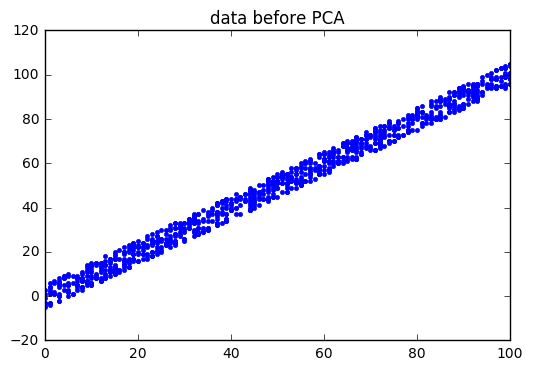

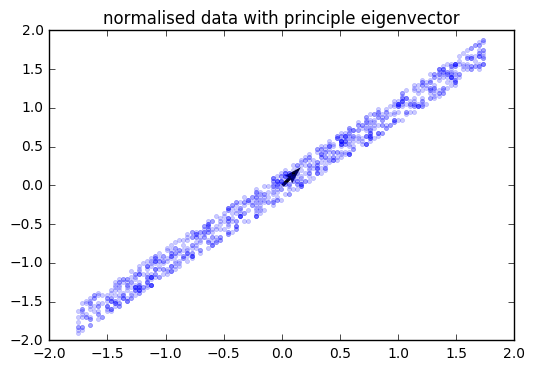

percentage of variance explained:  1.0


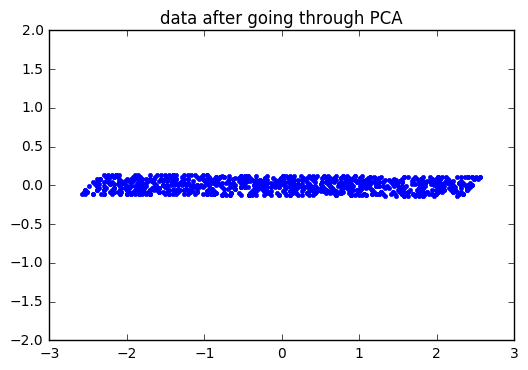

In [48]:
def PCA(data, n_components = 2):
    try:
        data = np.array(data)                                 # format data as a numpy array.
    except:
        return 'data not in the correct format'
    meanlist = data.mean(axis = 0)                            # identify standard deviation and mean for each feature.
    stdlist = np.std(data, axis = 0)
    newdata = []
    for i in range(len(data)):
        newdata.append((data[i] - meanlist)/stdlist)          # normalise features with respect to mean and variance.
    newerdata = np.array(newdata)                             # format to numpy array. 
    plt.plot(newerdata.T[0], newerdata.T[1], '.', alpha = 0.2)
    covmat = np.dot(newerdata.T, newerdata)                   # construct covariance matrix from normalised data.
    values, vectors = np.linalg.eigh(covmat)                  # identify eigen values and vectors of the covariance matrix.
    vallist = list(enumerate(values))                         # label and then sort eigenvalues based on value.
    sortenu = sorted(vallist, key=lambda x:x[1], reverse = True)
    vectors = vectors.T
    if n_components > len(sortenu):                           # check that the number of requested components does not exceed 
        print('too many principal components requested')      # the number of original features.
    desiredvecs = []
    for n in range(n_components):
        desiredvecs.append(vectors[sortenu[n][0]])            # index and extract n vectors associated with the n largest 
    desiredvecs = np.array(desiredvecs)                       # eigenvectors. 
    newodata = np.dot(newerdata, desiredvecs.T)               # project normalised data onto the transpose of the eigenvectors
    origin = [0], [0]
    plt.quiver(*origin, desiredvecs[0,0], desiredvecs[0,1])   # plot the principle eigenvector onto the normalised data.
    plt.title('normalised data with principle eigenvector')
    plt.show()
    desired = 0
    full = 0
    for i in range(len(sortenu)):                             # compute the percent of variance of the original dataset that
        if i <= n_components-1:                               # is still explained by the new lower dimension projection. 
            desired = desired + sortenu[i][1]
            full = full + sortenu[i][1]
        else:
            full = full + sortenu[i][1]
    pov = desired/full
    print('percentage of variance explained: ', pov)
    return newodata                                          # matrix to give the final result. 

# The following section visualises the process of PCA. 
xs = []
ys = []
for i in range(1000):             # generate a 2D dataset with a high degree of correlation. 
    num = random.randint(0,100)
    xs.append(num)
    ys.append(num + random.randint(-5,5))  # change the sign (-num --> num) to flip the correlation. 
plt.plot(xs,ys, '.')              # plot the original dataset.
plt.title('data before PCA')
plt.show()
dato = np.array([xs,ys]).T        
pcadata = PCA(dato, n_components = 2)     # compute PCA on this dataset.
plt.ylim(-2,2)
plt.xlim(-3,3)
plt.plot(pcadata[:,0], pcadata[:,1], '.') # plot the data projected onto the new axes. 
plt.title('data after going through PCA')
plt.show()

### 3) regression/ visualisation

In [ ]:
os.chdir('/home/brain/')
data = pd.read_excel('dHCP_data_harry_matched.xlsx')                          # open demographic data
os.chdir('/home/brain/Documents/icadatacode/newskeletons/skel_flica_output/')
compdat = open('subjectCoursesOut.txt')                                       # open participant weight vectors
compdata = []
count = 0
for i in compdat:                                # The weight vectors are in a text file and need to be formatted into a matrix.
    if count > 5:
        compdata.append(i.split('\t')[:-1])
    count = count + 1
components_data = pd.DataFrame(compdata, columns = [str(x) for x in range(20)]).astype(str).astype(float) # matrix -> pandas.
components_data['IndexInImaging'] = components_data.index           # demographic and IC data are indexed together.
big_data = pd.merge(data,components_data, on = 'IndexInImaging')
big_data = big_data.drop('participationid', axis = 1) 
trainmathold = []
no_dom_data = big_data.drop(['IndexInImaging', '0', '5'], axis = 1) # columns with no information that may confound are removed.
big_data = no_dom_data[no_dom_data.cbcl_total > -500]     # outlier removal.
collist = []
for i in big_data.columns.values[21:]:           # sk learn needs a matrix (not pandas) so ICs are reformatted as a matrix. 
    collist.append(str(i))
    if i != 'IndexInImaging':
        trainmathold.append(list(big_data[i]))
trainmathold.append(list(big_data['Age at Birth'])) # age is included in regression as we expect this to potentially be
collist.append('Age at Birth')                      # an underlying correlate. 
trainmathold.append(list(big_data['Age at Scan']))
collist.append('Age at Scan')
trainmathold = np.array(trainmathold)
trainmathold = trainmathold.T
for i in range(len(trainmathold)):
    trainmathold[i] = [((x - np.mean(trainmathold[i]))/np.var(trainmathold[i])) for x in trainmathold[i]] # normalise IC data.
    
ridge = sk_lin.RidgeCV(alphas = [0.1,0.3,0.7,1,1.5,3,5,8,10], cv = 10) # establish ridge regression model with multiple lambdas
coefdict = defaultdict(int)                                         # and 10 fold cross validation. 
ridge_result = ridge.fit(trainmathold, list(big_data['qchat_total'])) # us model to predict q-chat score. 
regscore = defaultdict(int)

preds = ridge_result.predict(trainmathold)                  # find the MSE of the model by testing on the training data
stand_error = []
for j in range(len(preds)):                                 # then find absolute differences differences between real and preds.
    stand_error.append((preds[j] - (list(big_data['qchat_total'])[j]))**2)
stand_error = np.mean(stand_error)
reg_cov = np.cov(trainmathold)                   # generate covariance matrix of IC data.

multi_cov = np.zeros((len(reg_cov), len(reg_cov))) # find the variance in the ICs.

for i in range(len(reg_cov)):
    for j in range(len(reg_cov[i])):
        multi_cov[i][j] = stand_error * reg_cov[i][j]        # find a t statistic for each IC based on MSE and varicance - 
stand_error = np.sqrt(np.diag(multi_cov))           # this tells us if it is significant as a predictor. 
for i in range(len(ridge_result.coef_)):
    regscore[collist[i]] = np.abs(ridge_result.coef_[i])/stand_error[i]
plt.figure(figsize = (14,6))
plt.bar(range(len(ridge_result.coef_)), np.abs(ridge_result.coef_), width = 0.4, align = 'edge') # plot coefficients. 
plt.xticks(range(len(ridge_result.coef_)), collist, rotation = 20)
plt.title('raw coefficients, ridge regression predicting qchat')
plt.ylabel('coefficient value')
plt.xlabel('feature')
plt.savefig('rawcoefsnew.png')
for key,value in regscore.items():
    print(key, value)

premies = no_dom_data[no_dom_data['Age at Birth'] < 37]       # stratify data based on age at birth (prematurity < 37 weeks).
posties = no_dom_data[no_dom_data['Age at Birth'] > 37]
plt.figure()
plt.plot(list(premies['Age at Scan']), list(premies['2']), '.', color = 'r') # plot premies and posties in different colours.
plt.plot(list(posties['Age at Scan']), list(posties['2']), '.', color = 'g')
plt.title('Age at scan plotted against IC2, stratified at 37 weeks')
plt.xlabel('Age at scan')
plt.ylabel('IC Z score')
plt.text(30, -2.5, 'red < 37 weeks, green > 37 weeks')
plt.show()